# halo_cnn tutorial

This notebook provides a tutorial for creating a halo_cnn pipeline using the halo_cnn data and model module. 

In this tutorial, we'll make a data pipeline for the CNN$_{2D}$ model, which regresses $\log_{10}\left[M_{200c}\right]$ over the space of joint $\{v_{los}, R_{proj}\}$ distributions. We'll use 10-fold cross-validation to train and evaluate 10 models on independent train and test datasets.

## Imports

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import halo_cnn
from halo_cnn.model import HaloCNNRegressor
from halo_cnn.data import HaloCNNRegressManager

from tools.plot_tools import binned_plot

Using Theano backend.


In [2]:
# Global parameters
nfolds = 10 # use 10-fold cross-validation
epochs = 20 # train for 20 epochs

## Load and Preprocess Data

In [3]:
data_manager = HaloCNNRegressManager(input_shape=(48,48),
                                     bandwidth=0.25,
                                     nfolds=nfolds,
                                     val_split=0.1,
                                     mass_range_train=(None, None), # full range of masses
                                     mass_range_test=(10**14, 10**15),
                                     dn_dlogm=10.**-5.2, dlogm=0.02
                                    )

In [4]:
# Load catalogs
catalog = data_manager.load_catalog('/home/mho1/scratch/halo_cnn/data_mocks/Rockstar_UM_z=0.000_contam.p')

print('\n~~~~ Catalog Parameters ~~~~')
for key in catalog.par:
    print(key,':',catalog.par[key])

Loading catalog from: /home/mho1/scratch/halo_cnn/data_mocks/Rockstar_UM_z=0.000_contam.p

~~~~ Catalog Parameters ~~~~
catalog_name : Rockstar_UM_z=0.000
z : 0.0
min_mass : 31622776601683.793
min_richness : 10
aperture : 1.6
vcut : 2500.0
cosmo : {'H_0': 100, 'Omega_m': 0.307115, 'Omega_l': 0.692885, 'c': 299792.458}


In [5]:
# Preprocess data
data = data_manager.preprocess(catalog, ['vlos','Rproj'], n_proc=10)

100%|██████████| 64366/64366 [01:24<00:00, 758.10it/s] 


In [6]:
# Assign variables and regularize dataset
X = data['pdf']
Y = data_manager.regularize(data['logmass'])

in_train = data['in_train']
in_test = data['in_test']
in_val = data['in_val']
fold = data['fold']

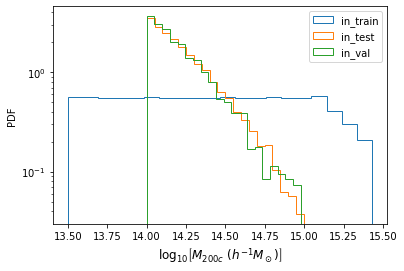

In [15]:
# Plot mass distribution of train and test sets

plt.semilogy()

plt.hist(data['logmass'][in_train], 
         density=True, bins=20, histtype='step', label='in_train')
plt.hist(data['logmass'][in_test], 
         density=True, bins=20, histtype='step', label='in_test')
plt.hist(data['logmass'][in_val], 
         density=True, bins=20, histtype='step', label='in_val')

plt.xlabel(r'$\log_{10}\left[M_{200c}\ (h^{-1}M_\odot)\right]$', fontsize=12)
plt.ylabel('PDF')
plt.legend()

## Initialize and Train Models

In [8]:
# Initialize models for each fold
models = [HaloCNNRegressor(input_shape=(48,48), epochs=epochs) for i in range(10)]

In [9]:
logmass_pred = np.zeros(shape=Y.shape)

for i in range(nfolds):
    print('\n~~~~~~~~~~ Fold %d ~~~~~~~~~~'%i)
    # Augment training data by flipping along v_los axis
    X_train, Y_train = data_manager.augment_flip(X = X[in_train & (fold != i)],
                                                 Y = Y[in_train & (fold != i)])
    X_val, Y_val = X[in_val & (fold == i)], Y[in_val & (fold == i)]
    
    # Train model
    _ = models[i].fit(X_train, Y_train, x_val=X_val, y_val=Y_val, verbose=1)



~~~~~~~~~~ Fold 0 ~~~~~~~~~~
Train on 20578 samples, validate on 585 samples
Epoch 1/20
20578/20578 [==============================] - 6s 281us/step - loss: 0.0950 - val_loss: 0.0386
Epoch 2/20
20578/20578 [==============================] - 6s 288us/step - loss: 0.0515 - val_loss: 0.0343
Epoch 3/20
20578/20578 [==============================] - 6s 296us/step - loss: 0.0389 - val_loss: 0.0244
Epoch 4/20
20578/20578 [==============================] - 6s 293us/step - loss: 0.0350 - val_loss: 0.0296
Epoch 5/20
20578/20578 [==============================] - 6s 294us/step - loss: 0.0321 - val_loss: 0.0241
Epoch 6/20
20578/20578 [==============================] - 6s 296us/step - loss: 0.0306 - val_loss: 0.0276
Epoch 7/20
20578/20578 [==============================] - 6s 296us/step - loss: 0.0298 - val_loss: 0.0234
Epoch 8/20
20578/20578 [==============================] - 6s 295us/step - loss: 0.0286 - val_loss: 0.0271
Epoch 9/20
20578/20578 [==============================] - 6s 297us/step - 

Epoch 15/20
20318/20318 [==============================] - 6s 307us/step - loss: 0.0260 - val_loss: 0.0302
Epoch 16/20
20318/20318 [==============================] - 6s 308us/step - loss: 0.0270 - val_loss: 0.0300
Epoch 17/20
20318/20318 [==============================] - 6s 306us/step - loss: 0.0262 - val_loss: 0.0304
Epoch 18/20
20318/20318 [==============================] - 6s 307us/step - loss: 0.0258 - val_loss: 0.0250
Epoch 19/20
20318/20318 [==============================] - 6s 307us/step - loss: 0.0255 - val_loss: 0.0318
Epoch 20/20
20318/20318 [==============================] - 6s 307us/step - loss: 0.0250 - val_loss: 0.0284

~~~~~~~~~~ Fold 4 ~~~~~~~~~~
Train on 20486 samples, validate on 537 samples
Epoch 1/20
20486/20486 [==============================] - 5s 266us/step - loss: 0.0948 - val_loss: 0.0304
Epoch 2/20
20486/20486 [==============================] - 6s 284us/step - loss: 0.0391 - val_loss: 0.0275
Epoch 3/20
20486/20486 [==============================] - 6s 299us/s

Epoch 9/20
20468/20468 [==============================] - 6s 301us/step - loss: 0.0266 - val_loss: 0.0318
Epoch 10/20
20468/20468 [==============================] - 6s 297us/step - loss: 0.0258 - val_loss: 0.0298
Epoch 11/20
20468/20468 [==============================] - 6s 295us/step - loss: 0.0250 - val_loss: 0.0289
Epoch 12/20
20468/20468 [==============================] - 6s 296us/step - loss: 0.0251 - val_loss: 0.0317
Epoch 13/20
20468/20468 [==============================] - 6s 295us/step - loss: 0.0245 - val_loss: 0.0353
Epoch 14/20
20468/20468 [==============================] - 6s 297us/step - loss: 0.0244 - val_loss: 0.0267
Epoch 15/20
20468/20468 [==============================] - 6s 296us/step - loss: 0.0241 - val_loss: 0.0282
Epoch 16/20
20468/20468 [==============================] - 6s 298us/step - loss: 0.0245 - val_loss: 0.0256
Epoch 17/20
20468/20468 [==============================] - 6s 297us/step - loss: 0.0237 - val_loss: 0.0264
Epoch 18/20
20468/20468 [=============

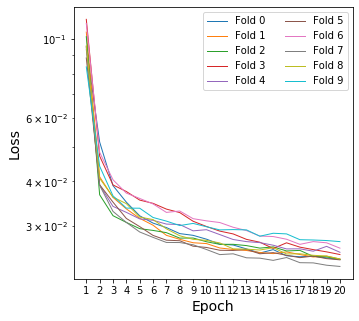

In [10]:
f = plt.figure(figsize=(5,5))

plt.semilogy()
for i in range(nfolds):
    plt.plot(np.arange(epochs)+1, models[i].history.history['loss'], 
             linewidth=1, label='Fold %i'%i)

plt.xticks(np.arange(epochs)+1)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(ncol=2)

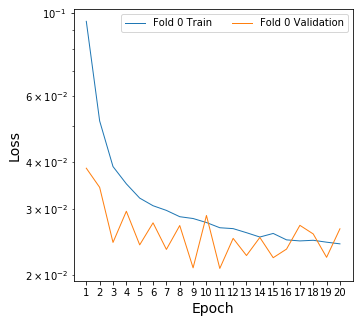

In [11]:
f = plt.figure(figsize=(5,5))

i = 0
plt.semilogy()
plt.plot(np.arange(epochs)+1, models[i].history.history['loss'], 
         linewidth=1, label='Fold %i Train'%i)
plt.plot(np.arange(epochs)+1, models[i].history.history['val_loss'], 
         linewidth=1, label='Fold %i Validation'%i)

plt.xticks(np.arange(epochs)+1)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(ncol=2)

## Evaluate models on test set

In [12]:
logmass_pred = np.zeros(shape=Y.shape)

for i in range(10):
    # Load test inputs
    X_test = X[in_test & (fold == i)]
    
    # Predict on test inputs
    Y_pred = models[i].predict(X_test)
    
    np.put(a=logmass_pred,
           ind=np.where(in_test & (fold==i))[0],
           v=data_manager.deregularize(Y_pred)
          )

Text(0, 0.5, '$\\epsilon$')

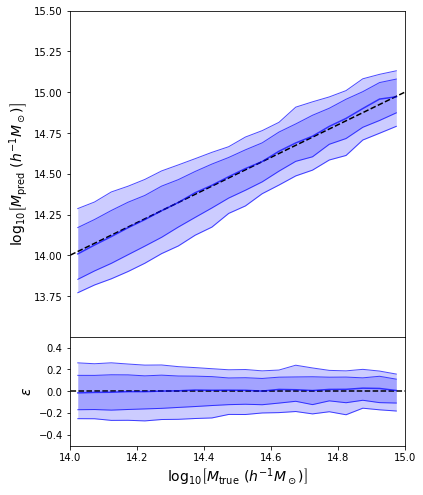

In [14]:
f = plt.figure(figsize=(6,8))
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[3,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])

ax1.plot(np.arange(13,16,0.1),np.arange(13,16,0.1),'k--')
_ = binned_plot(data['logmass'][in_test], 
                logmass_pred[in_test], 
                n=20, percentiles=[0,35,45], 
                color='b', ax=ax1)

ax1.set_xlim(14,15)
ax1.set_ylim(13.5,15.5)
ax1.set_xticks([])
ax1.set_yticks(ax1.get_yticks()[1:])
ax1.set_ylabel(r'$\log_{10}\left[M_\mathrm{pred}\ (h^{-1}M_\odot)\right]$', fontsize=14)


ax2 = f.add_subplot(gs[1,0])

ax2.plot(np.arange(13,16,0.1),[0]*30,'k--')
_ = binned_plot(data['logmass'][in_test], 
                logmass_pred[in_test] - data['logmass'][in_test], 
                n=20, percentiles=[0,35,45], 
                color='b', ax=ax2)
ax2.set_xlim(14,15)
ax2.set_ylim(-0.5,0.5)
ax2.set_xlabel(r'$\log_{10}\left[M_\mathrm{true}\ (h^{-1}M_\odot)\right]$', fontsize=14)
ax2.set_ylabel(r'$\epsilon$', fontsize=14)